# Analyzing with iNNvestigate

**iNNvestigate** got created to make analyzing neural network's predictions easy! The library should help the user to focus on research and development by providing implemented analysis methods and facilitating rapid development of new methods. In this notebook we will show you how to use **iNNvestigate** and for a better understanding we recommend to read [iNNvestigate neural networks!](https://jmlr.org/papers/v20/18-540.html) first! How to use **iNNvestigate** you can read in this notebook: [Developing with iNNvestigate](introduction_development.ipynb)

-----

**The intention behind iNNvestigate is to make it easy to use analysis methods, but it is not to explain the underlying concepts and assumptions. Please, read the according publication(s) when using a certain method and when publishing please cite the according paper(s) (as well as the [iNNvestigate paper](https://jmlr.org/papers/v20/18-540.html)). Thank you!** You can find most related publication in [iNNvestigate neural networks!](https://jmlr.org/papers/v20/18-540.html) and in the README file.

### Analysis methods

The field of analyizing neural network's predictions is about gaining insights how and why a potentially complex network gave as output a certain value or choose a certain class over others. This is often called interpretability or explanation of neural networks. We just call it analyzing a neural network's prediction to be as neutral as possible and to leave any conclusions to the user.

Most methods have in common that they analyze the input features w.r.t. a specific neuron's output. Which insights a method reveals about this output can be grouped into (see [Learning how to explain: PatternNet and PatternAttribution](https://arxiv.org/abs/1705.05598)):

* **function:** analyzing the operations the network function uses to extract or compute the output. E.g., how would changing an input feature change the output.
* **signal:** analyzing the components of the input that cause the output. E.g., which parts of an input image or which directions of an input are used to determine the output.
* **attribution:** attributing the "importance" of input features for the output. E.g., how much would changing an input feature change the output.

----

In this notebook we will introduce methods for each of these categories and along show how to use different features of **iNNvestigate**, namely how to:

* analyze a prediction.
* train an analyzer.
* analyze a prediction w.r.t to a specific output neuron.

Let's dive right into it!

### Run on Colab
> Colab uses per default tensorflow 1.15 which was not used for development of `iNNvestigate`  
> Switch to colab GPU runtime for performance

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/albermax/innvestigate/blob/master/examples/notebooks/introduction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>



In [1]:
import os
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 1.x
    IS_COLAB = True
    if not os.path.exists('/content/innvestigate'):
        !git clone https://github.com/albermax/innvestigate.git
        !pip install /content/innvestigate --no-deps
    %cd /content/innvestigate/examples/notebooks
except Exception:
    IS_COLAB = False

! pip install deeplift


### Training a network

To analyze a network, we need a network! As a base for **iNNvestigate** we chose the Keras deep learning library, because it is easy to use and allows to inspect build models.

In this first piece of code we import all the necessary modules:

In [2]:
%matplotlib inline 
import warnings
warnings.simplefilter('ignore')
import imp
import matplotlib.pyplot as plot
import numpy as np
import os
import keras
import keras.backend
import keras.layers
import keras.models
import keras.utils
import innvestigate
import innvestigate.utils as iutils
from tensorflow.keras.datasets import fashion_mnist

# Use utility libraries to focus on relevant iNNvestigate routines.
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: '../utils_mnist.py'

to load the data:

In [3]:

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape((len(train_images),28,28,1))
test_images = test_images.reshape((len(test_images),28,28,1))

data_not_preprocessed = [train_images, train_labels, test_images, test_labels]

label_to_class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

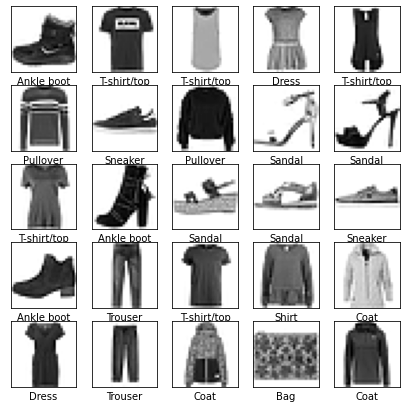

In [4]:
# to give you an overview of the data plot first 25 images with corresponding labels
plot.figure(figsize=(7,7))
for i in range(25):
    plot.subplot(5,5,i+1)
    plot.xticks([])
    plot.yticks([])
    plot.grid(False)
    plot.imshow(data_not_preprocessed[0][i].reshape(28,28), cmap=plot.cm.binary)
    plot.xlabel(label_to_class_name[data_not_preprocessed[1][i]])
plot.show()

In [5]:
data_processed = data_not_preprocessed[0] / 255, data_not_preprocessed[2] / 255
data = (data_processed[0], data_not_preprocessed[1],
        data_processed[1],data_not_preprocessed[3])


and to now create and train a CNN model:

In [6]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(optimizer = 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# fit model to train data
# you cann add more 'iterations' by raising the parameter epochs
log = model.fit(data_processed[0], 
                data_not_preprocessed[1], 
                batch_size= 256,
                epochs = 20,         
                validation_data = (data_processed[1], data_not_preprocessed[3]))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.4896 - accuracy: 0.8269 - val_loss: 0.3405 - val_accuracy: 0.8831
Epoch 2/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.3169 - accuracy: 0.8851 - val_loss: 0.2949 - val_accuracy: 0.8931
Epoch 3/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.2690 - accuracy: 0.9021 - val_loss: 0.2689 - val_accuracy: 0.9030
Epoch 4/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.2397 - accuracy: 0.9112 - val_loss: 0.2453 - val_accuracy: 0.9096
Epoch 5/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.2145 - accuracy: 0.9204 - val_loss: 0.2248 - val_accuracy: 0.9184
Epoch 6/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.1944 - accuracy: 0.9288 - val_loss: 0.2232 - val_ac

In [7]:
# make predictions for test data
predictions = model.predict(data_processed[1])


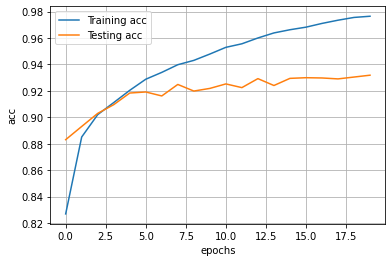

In [8]:
# plot accuracy per epoch
plot.plot(log.history['accuracy'], label='Training acc')
plot.plot(log.history['val_accuracy'], label='Testing acc')
plot.xlabel("epochs")
plot.ylabel("acc")
plot.legend()
plot.grid()

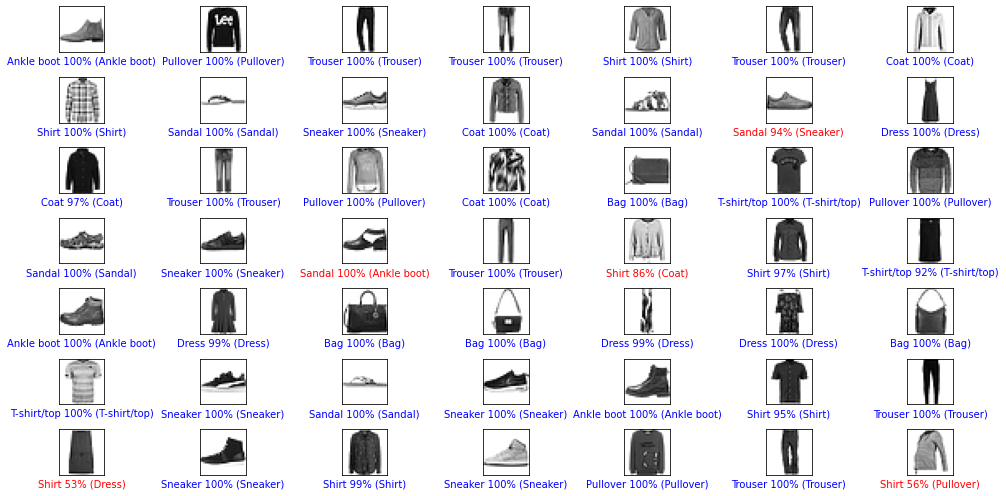

In [9]:
# This function plots the first n predictions with their true label (in brackets) and image
train_images=train_images.reshape(60000,28,28)
test_images=test_images.reshape(10000,28,28)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plot.xticks([])
  plot.yticks([])
  plot.imshow(img, cmap=plot.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plot.xlabel("{} {:2.0f}% ({})".format(label_to_class_name[predicted_label],
                                100*np.max(predictions_array),
                                label_to_class_name[true_label]),
                                color=color)

# plot prediction and image
num_rows = 7
num_cols = 7
num_images = num_rows*num_cols
plot.figure(figsize=(2*num_cols, 1*num_rows))
for i in range(num_images):
  plot.subplot(num_rows, num_cols, i+1)
  plot_image(i, predictions[i], test_labels, test_images)
plot.tight_layout()
plot.show()

## Analyzing a predicition

Let's first choose an image to analyze:

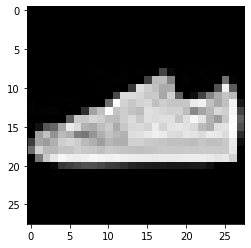

In [10]:
# Choosing a test image for the tutorial:
image = data[2][22:23]
plot.imshow(image.squeeze(), cmap='gray', interpolation='nearest')
plot.show()

In this first part we show how to create and use an analyzer. To do so we use an analyzer from *function* category, namely the gradient. The gradient shows how the linearized network function reacts on changes of a single feature.

This is simply done by passing the model without a softmax to the analyzer class.
For convience there is a function that creates an analyzer for you. It passes all the parameter on to the class instantiation:

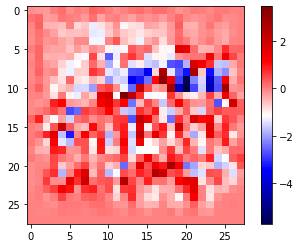

In [11]:
# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Displaying the gradient
plot.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plot.colorbar()
plot.show()

To emphasize different compontents of the analysis many people use instead of the "plain" gradient the absolute value or the square of it. With the gradient analyzer this can be done specifying additional parameters when creating the analyzer:

In [12]:
# Creating a parameterized analyzer
abs_gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm, postprocess="abs")
square_gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm, postprocess="square")

Similar other analyzers can be parameterized.

Now we visualize the result by projecting the gradient into a gray-color-image:

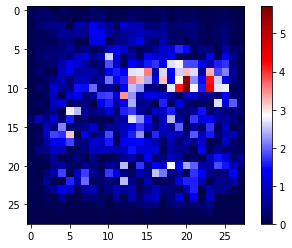

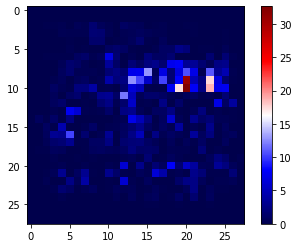

In [13]:
# Applying the analyzers
abs_analysis = abs_gradient_analyzer.analyze(image)
square_analysis = square_gradient_analyzer.analyze(image)

# Displaying the analyses, use gray map as there no negative values anymore
plot.imshow(abs_analysis.squeeze(), cmap='seismic', interpolation='nearest')
plot.colorbar()
plot.show()
plot.imshow(square_analysis.squeeze(), cmap='seismic', interpolation='nearest')
plot.colorbar()
plot.show()

## Training an analyzer

Some analyzers are data-dependent and need to be trained. In **iNNvestigate** this realized with a SKLearn-like interface. In the next piece of code we train the method PatternNet that analyzes the *signal*:

In [14]:
# Creating an analyzer
patternnet_analyzer = innvestigate.create_analyzer("pattern.net", model_wo_sm, pattern_type="relu")

# Train (or adapt) the analyzer to the training data
patternnet_analyzer.fit(data[0], verbose=True)

# Applying the analyzer
analysis = patternnet_analyzer.analyze(image)

Instructions for updating:
ksizes is deprecated, use sizes instead
Epoch 1/1
1875/1875 [==============================] - 10s 5ms/step - loss: 4.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000


And visualize it:

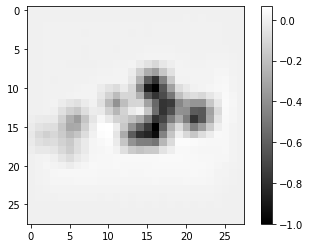

In [15]:
# Displaying the signal (projected back into input space)
plot.imshow(analysis.squeeze()/np.abs(analysis).max(), cmap="gray", interpolation="nearest")
plot.colorbar()
plot.show()

## Choosing the output neuron

In the previous examples we always analyzed the output of the neuron with the highest activation. In the next one we show how one can choose the neuron to analyze:

In [16]:
# Creating an analyzer and set neuron_selection_mode to "index"
inputXgradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model_wo_sm,
                                                       neuron_selection_mode="index")


The gradient\*input analyzer is an example from the *attribution* category and we visualize it by means of a colored heatmap to highlight positive and negative attributions:

Analysis w.r.t. to neuron 0


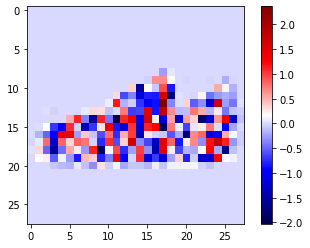

Analysis w.r.t. to neuron 1


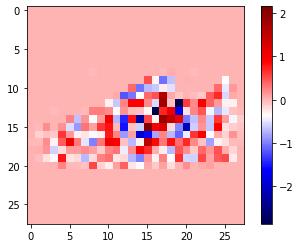

Analysis w.r.t. to neuron 2


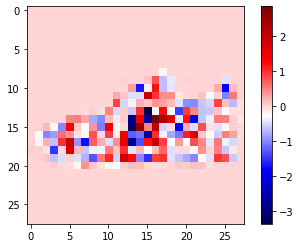

Analysis w.r.t. to neuron 3


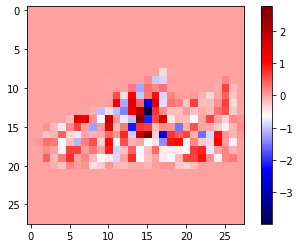

Analysis w.r.t. to neuron 4


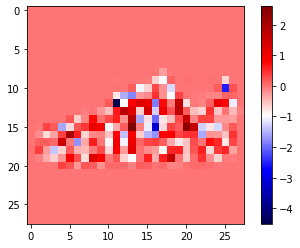

Analysis w.r.t. to neuron 5


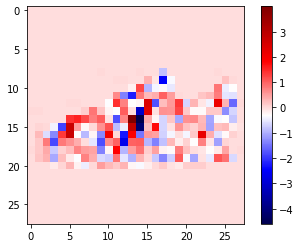

Analysis w.r.t. to neuron 6


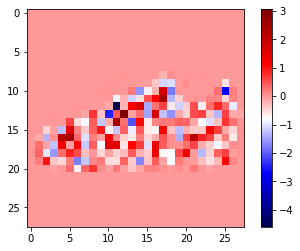

Analysis w.r.t. to neuron 7


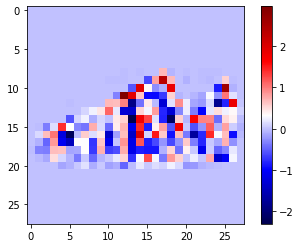

Analysis w.r.t. to neuron 8


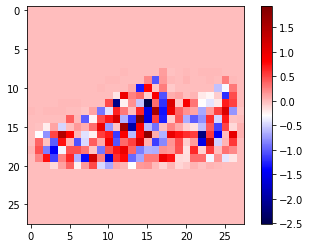

Analysis w.r.t. to neuron 9


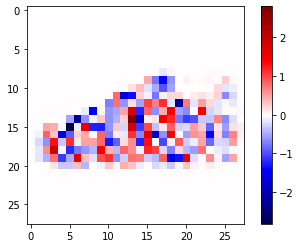

In [17]:
for neuron_index in range(10):
    print("Analysis w.r.t. to neuron", neuron_index)
    # Applying the analyzer and pass that we want 
    analysis = inputXgradient_analyzer.analyze(image, neuron_index)
    
    # Displaying the gradient
    plot.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
    plot.colorbar()
    plot.show()

# more methods

In [18]:
# Scale to [0, 1] range for plotting.
input_range = [0, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},mnistutils.graymap,        "SmoothGrad"),
    ## Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    ("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"),

    ## Interaction
    ("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    ("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
    ("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
    ("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"),
    ("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
                                                        mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
]

In [19]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)
    

Epoch 1/1
235/235 [==============================] - 5s 20ms/step - loss: 4.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 5s 20ms/step - loss: 4.0000 - broadcast_9_loss: 1.0000 - broadcast_10_loss: 1.0000 - broadcast_11_loss: 1.0000 - broadcast_12_loss: 1.0000


In [20]:
%%capture

n = 25
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

<Figure size 432x288 with 0 Axes>

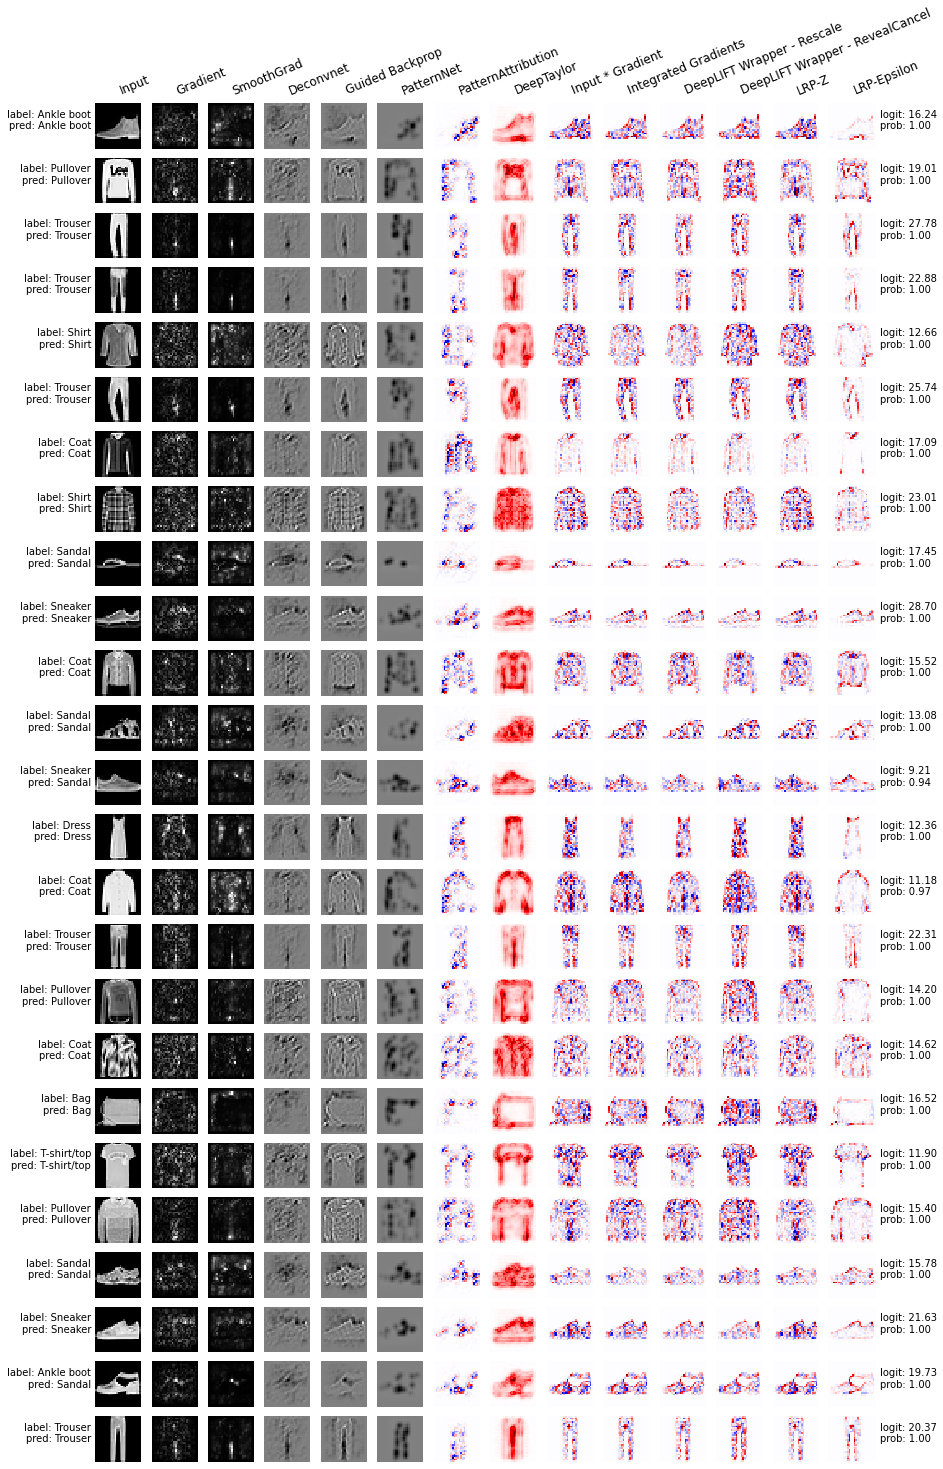

In [21]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils = imp.load_source("utils", "../utils.py")

eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

## Additional resources

If you would like to learn more we have more notebooks for you, for example: [Comparing methods on MNIST](mnist_method_comparison.ipynb), [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)

If you want to know more about how to use the API of **iNNvestigate** look into: [Developing with iNNvestigate](introduction_development.ipynb)